# Capstone Project - The Battle of Neighborhoods

### Table of Contents
* Introduction: Business Problem
* Data
* Methodology
* Analysis
* Results and Discussion
* Conclusion

## A. Introduction/Business Problem

California is one of many state located in the Western United States. It is the third most populous state among other states of United States. The most popular county in California is Los Angeles, as it is also being the most populous county in the United States, having around four million residents.

Los Angeles is becoming a good place to set up business following the fact that it has the third-largest metropolitan economy in the world. One of the booming business in current trend is gym or sport centre. Moreover, Los Angeles is famous for people who is pursuing career in entertainment industry, which makes it important for them to take care of their body, beauty, and health. That makes Gym location being one of important indicator when people consider and choosing where to live. Apart from that, opening new gym means that we need to consider its preconditioned location too, like its neighborhood characteristic, population, and also nearby competitor. It's causing a big problem to answer, where is the most recommended neighborhood in Los Angeles to open gym?

## B. Data

To solve this problem it is important to gain proper data that are needed for analyzing characteristic of neighborhoods in Los Angeles. Some data related to Los Angeles which are needed such as:
* Name of region and neighborhoods
    - Source: http://maps.latimes.com/neighborhoods/neighborhood/list/
* Location of neighborhoods (Langitude and Latitude)
    - To derived map and get common venues around neighborhoods 
    - Source: geocoders and "http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/la-county-neighborhoods-v5.geojson"

* Number of residents
    - To get views and compare the population on every neighborhood 
    - Source: http://maps.latimes.com/neighborhoods/population/total/neighborhood/list/
* Common venues around every city
    - To get views and compare characteristic on every neighborhood using venue's characteristic
    - Source: Foursquare


## C. Methodology

Method we will use are divided into 3 parts. First, importing all data needed and merging into a main dataframe. Second, rank common venues around every city for analyzing neighborhood characteristic. Third, checking potential neighborhood by gym competitor nearby.

1.  For importing data we use all the source stated before. We will collect all 272 name of neighborhoods around LA, get number of residents data for all neighborhoods, location(by latitude and longitude), and venues around every neighborhoods by foursquare data.

2. We explore the common venues around every neighborhood by making rank of the 10 most common venues. It can be done by grouping all venues and looking at the means of each venue category appearance in every neighborhood. We then cluster all the neighborhoods by its common venues by using kMeans.

3. Finally, we do a recheck of a potential neighborhood by checking locations of another gym as a business competitor within 3.5 km from neighborhood centre.

## D. Analysis

In [2]:
import numpy as np
import pandas as pd 
import requests
import json


!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

! pip install folium==0.5.0
import folium # plotting library

!pip install bs4
from bs4 import BeautifulSoup

print('Folium installed')
print('Libraries imported.')

     |████████████████████████████████| 112kB 5.8MB/s eta 0:00:01
     |████████████████████████████████| 122kB 23.0MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
Folium installed
Libraries imported.


First, we will import the neighborhood list data from the LA times website and make it into a pandas dataframe

In [3]:
# import neighborhood data from source URL
url = "http://maps.latimes.com/neighborhoods/neighborhood/list/"
data = requests.get(url).text 
table = BeautifulSoup(data, 'html5lib')
tables = table.find_all('table')
tables[0].prettify()

# make empty table
df = pd.DataFrame(columns=["Neighborhood", "Region"])

# convert html into table data
for row in tables[0].tbody.find_all("tr"):
    col = row.find_all("td")
    if (col != []):
        neigh = col[0].text
        region = col[1].text
        df = df.append({"Neighborhood":neigh, "Region":region}, ignore_index=True)
        

df = df.replace(' ','_', regex=True)
df = df.replace('\n____________________','', regex=True)
df = df.replace('\n________________','', regex=True)
df = df.replace('_',' ', regex=True)
df

,Neighborhood,Region
0,Acton,Antelope Valley
1,Adams-Normandie,South L.A.
2,Agoura Hills,Santa Monica Mountains
3,Agua Dulce,Northwest County
4,Alhambra,San Gabriel Valley
...,...,...
267,Willowbrook,South L.A.
268,Wilmington,Harbor
269,Windsor Square,Central L.A.
270,Winnetka,San Fernando Valley


After getting all name of the neighborhood and region they belong to, we import population data from LA times and turn it into another pandas dataframe

In [4]:
# import population data from source URL
url2 = "http://maps.latimes.com/neighborhoods/population/total/neighborhood/list/"
data2 = requests.get(url2).text 
table2 = BeautifulSoup(data2, 'html5lib')
tables2 = table2.find_all('table')

# make empty table
dfpop = pd.DataFrame(columns=["Neighborhood", "Population"])

# convert html into table data
for row in tables2[1].tbody.find_all("tr"):
    col = row.find_all("td")
    if (col != []):
        neigh = col[1].text
        pop = col[2].string
        dfpop = dfpop.append({"Neighborhood":neigh, "Population":pop}, ignore_index=True)

dfpop = dfpop.replace(' ','_', regex=True)
dfpop = dfpop.replace('\n________________________','', regex=True)
dfpop = dfpop.replace('\n____________________','', regex=True)
dfpop = dfpop.replace('_',' ', regex=True)
dfpop = dfpop.replace(',','', regex=True)

dfpop['Population'] = pd.to_numeric(dfpop.Population, errors='coerce')

dfpop

,Neighborhood,Population
0,Long Beach,462731
1,Glendale,195047
2,Santa Clarita,157447
3,Pomona,150269
4,Torrance,137933
...,...,...
260,Lake Hughes,571
261,Hasley Canyon,423
262,West San Dimas,309
263,Unincorporated Catalina Island,139


We then merge both dataframe, sorting it to the highest number of population, and finally dropping empty data

In [5]:
# Merge both dataframe
dfnew = df.merge(dfpop, on='Neighborhood', how='left')
dfnew

#Sort by highest population
dfnew.sort_values(by=['Population'], ascending=False).dropna().reset_index(drop=True)

,Neighborhood,Region,Population
0,Long Beach,Harbor,462731.0
1,Glendale,Verdugos,195047.0
2,Santa Clarita,Northwest County,157447.0
3,Pomona,Pomona Valley,150269.0
4,Torrance,South Bay,137933.0
...,...,...,...
260,Lake Hughes,Northwest County,571.0
261,Hasley Canyon,Northwest County,423.0
262,West San Dimas,San Gabriel Valley,309.0
263,Unincorporated Catalina Island,Harbor,139.0


Next we are going to import all neighborhood's location by importing latitude and longitude from Geolocator, make new dataframe from the result, and then merging it into the main dataframe

In [6]:
location = [x for x in df['Neighborhood'].unique().tolist() 
            if type(x) == str]
latitude = []
longitude = []
for i in range(0, len(location)):
    try:
        address = location[i] + ', CA'
        geolocator = Nominatim(user_agent="ny_explorer")
        loc = geolocator.geocode(address)
        latitude.append(loc.latitude)
        longitude.append(loc.longitude)
        
    except:
        # in the case the geolocator does not work, then add nan element to list to keep the right size
        latitude.append(np.nan)
        longitude.append(np.nan)

In [11]:
# create a dataframe with the location, latitude and longitude
df_ = pd.DataFrame({'Neighborhood':location, 
                    'Neigh_latitude': latitude,
                    'Neigh_longitude':longitude})

# merge on main dataframe with location dataframe 
new_df = dfnew.merge(df_, on='Neighborhood', how='left').dropna().sort_values(by=['Population'], ascending=False).reset_index(drop=True)

new_df

,Neighborhood,Region,Population,Neigh_latitude,Neigh_longitude
0,Long Beach,Harbor,462731.0,33.769016,-118.191604
1,Glendale,Verdugos,195047.0,34.146942,-118.247847
2,Santa Clarita,Northwest County,157447.0,34.391664,-118.542586
3,Pomona,Pomona Valley,150269.0,34.055381,-117.751750
4,Torrance,South Bay,137933.0,33.835849,-118.340629
...,...,...,...,...,...
255,Lake Hughes,Northwest County,571.0,34.677458,-118.448711
256,Hasley Canyon,Northwest County,423.0,34.478487,-118.661582
257,West San Dimas,San Gabriel Valley,309.0,34.102245,-117.819512
258,Unincorporated Catalina Island,Harbor,139.0,49.152548,-55.340537


Now, we are going to see Los Angeles map along with their neighborhood

In [7]:
# Storing foursquare data
CLIENT_ID = '3MJJYZ2LJ3YSHHJALWHMB0WFQ3ZWJ5DGWRLFUMHIDED1OJFS' # your Foursquare ID
CLIENT_SECRET = 'IVU5EBWRPCJN1WTEQ1ZLHNVYVKAOGZ211DRYP5S1WZHXKRLL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
ACCESS_TOKEN = 'L1CEVSVZRKZVHPTNRV2TZWPBPLP4LEJAG515JFNDTU51SXQJ' # your FourSquare Access Token



In [50]:
address = 'Los Angeles, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of LA are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of LA are 34.0536909, -118.242766.


Checking map for population in every neighborhood

In [9]:
m = folium.Map(location=[34.0536909, -118.242766], zoom_start=10)
la_geo = "http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/la-county-neighborhoods-v5.geojson"

m.choropleth(geo_data=la_geo,
                    data = new_df,
                    columns=['Neighborhood','Population'],
                    key_on='feature.properties.name',
                    fill_color='YlOrRd',
                    fill_opacity=0.7, 
                    line_opacity=0.2,
                    legend_name='Population LA')
m

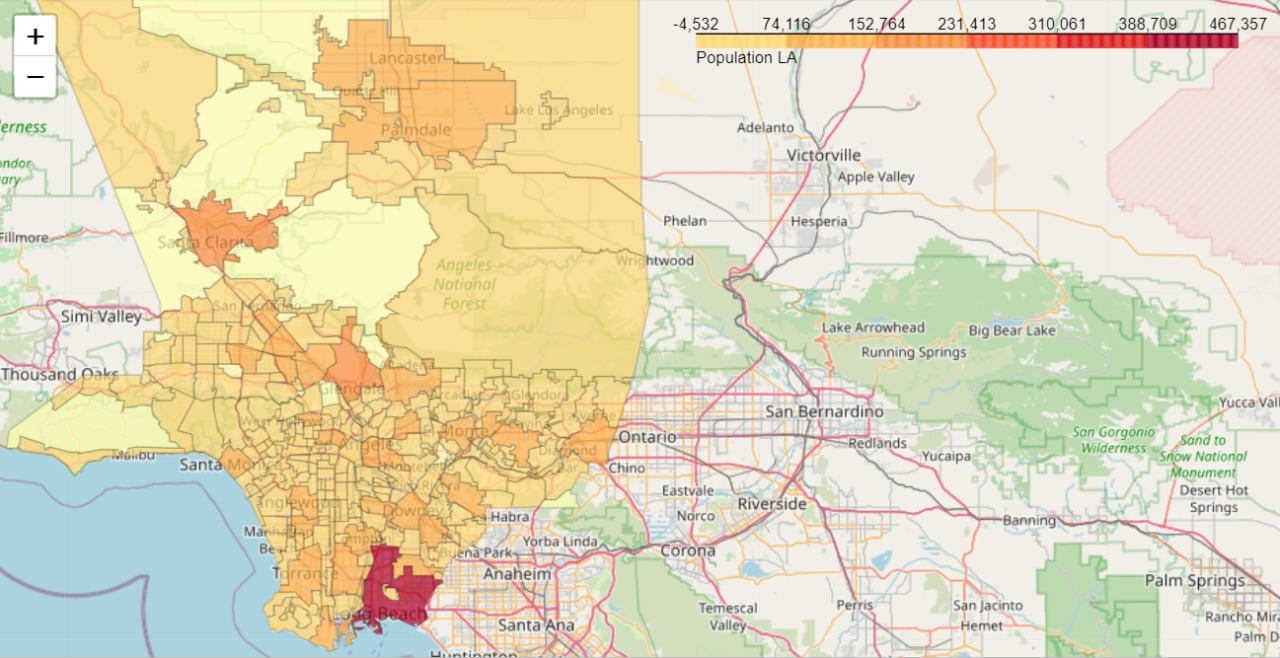

In this part we are going to get nearby venues to each of neighborhood. We then rank by counting each category and look for the mean of its appearance

In [28]:
# Function for getting nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
la_venues = getNearbyVenues(names=new_df['Neighborhood'], latitudes=new_df['Neigh_latitude'], longitudes=new_df['Neigh_longitude'])

Long Beach
Glendale
Santa Clarita
Pomona
Torrance
Pasadena
East Los Angeles
Lancaster
Palmdale
El Monte
Koreatown
Inglewood
Downey
West Covina
Westlake
Van Nuys
Norwalk
Burbank
South Gate
Compton
Boyle Heights
Carson
Hawthorne
Alhambra
Santa Monica
Whittier
San Pedro
Lakewood
North Hollywood
Hollywood
Sun Valley
Baldwin Park
Pacoima
East Hollywood
Bellflower
Lynwood
Sylmar
Panorama City
Redondo Beach
Pico Rivera
Reseda
Montebello
Huntington Park
Sherman Oaks
Florence-Firestone
Monterey Park
Woodland Hills
Valley Glen
Gardena
Highland Park
Northridge
Diamond Bar
Paramount
South Whittier
Hacienda Heights
Rosemead
Canoga Park
North Hills
Arcadia
Mid-City
Cerritos
Wilmington
Covina
Granada Hills
Glendora
Historic South-Central
Westwood
Rowland Heights
Winnetka
La Mirada
Vermont Square
Azusa
Bell Gardens
Florence
Altadena
Palms
Pico-Union
Encino
Mid-Wilshire
Westchester
Rancho Palos Verdes
La Puente
El Sereno
Central-Alameda
Echo Park
Harbor Gateway
San Gabriel
Culver City
West Hills
Venice

In [30]:
print(la_venues.shape)
la_venues.head()

(4580, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Long Beach,33.769016,-118.191604,Beachwood BBQ & Brewing,33.770070,-118.191100,Brewery
1,Long Beach,33.769016,-118.191604,L'Opera Ristorante,33.768296,-118.192375,Italian Restaurant
2,Long Beach,33.769016,-118.191604,George's Greek Cafe,33.768746,-118.192493,Greek Restaurant
3,Long Beach,33.769016,-118.191604,Gaucho Grill,33.769591,-118.192321,Argentinian Restaurant
4,Long Beach,33.769016,-118.191604,The Promenade,33.767750,-118.190775,Plaza


In [31]:
la_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adams-Normandie,12,12,12,12,12,12
Agoura Hills,8,8,8,8,8,8
Agua Dulce,9,9,9,9,9,9
Alhambra,44,44,44,44,44,44
Alondra Park,2,2,2,2,2,2
...,...,...,...,...,...,...
Willowbrook,4,4,4,4,4,4
Wilmington,15,15,15,15,15,15
Windsor Square,40,40,40,40,40,40


In [32]:
print('There are {} uniques categories.'.format(len(la_venues['Venue Category'].unique())))

There are 359 uniques categories.


In [33]:
# one hot encoding
la_onehot = pd.get_dummies(la_venues[['Venue Category']], prefix="", prefix_sep="")


# add neighborhood column back to dataframe
la_onehot['NeighborhoodName'] = la_venues['Neighborhood'] 

# move neighborhood column to the first column
# alternative: la_onehot.insert(0, 'Neighborhood', la_onehot.pop('Neighborhood'))
fixed_columns = [la_onehot.columns[-1]] + list(la_onehot.columns[:-1])
la_onehot = la_onehot[fixed_columns]

la_onehot.head()


,NeighborhoodName,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport,American Restaurant,Amphitheater,Andhra Restaurant,...,Watch Shop,Water Park,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Long Beach,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Long Beach,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Long Beach,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Long Beach,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Long Beach,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
la_grouped = la_onehot.groupby('NeighborhoodName').mean().reset_index()
la_grouped

,NeighborhoodName,ATM,Accessories Store,Adult Boutique,Advertising Agency,African Restaurant,Airport,American Restaurant,Amphitheater,Andhra Restaurant,...,Watch Shop,Water Park,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Adams-Normandie,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1,Agoura Hills,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2,Agua Dulce,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
3,Alhambra,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.022727,0.0,0.0,0.022727,0.0,0.0
4,Alondra Park,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,Willowbrook,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
240,Wilmington,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
241,Windsor Square,0.025,0.025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
242,Winnetka,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [67]:
# Function to sort mean values to rank nearby venue categories
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['NeighborhoodName']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['NeighborhoodName'] = la_grouped['NeighborhoodName']

for ind in np.arange(la_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(la_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()


,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams-Normandie,Sushi Restaurant,Latin American Restaurant,Dessert Shop,Gas Station,Park,Playground,Home Service,Taco Place,Grocery Store,Food
1,Agoura Hills,Indian Restaurant,Pizza Place,Gas Station,Gym,Chinese Restaurant,Pharmacy,Breakfast Spot,Deli / Bodega,Dim Sum Restaurant,Escape Room
2,Agua Dulce,Electronics Store,Restaurant,Grocery Store,Gift Shop,Café,Mexican Restaurant,Bakery,Pizza Place,Convenience Store,Fish & Chips Shop
3,Alhambra,Bakery,Chinese Restaurant,Sushi Restaurant,Café,Seafood Restaurant,Ice Cream Shop,Burger Joint,Lounge,Gastropub,Shoe Store
4,Alondra Park,Gym / Fitness Center,Park,Electronics Store,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market


Cluster the nighborhood by the most common venue

In [66]:
# set number of clusters
kclusters = 5

la_grouped_clustering = la_grouped.drop('NeighborhoodName', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(la_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([3, 0, 3, 0, 2, 3, 0, 0, 0, 3, 3, 0, 0, 0, 3, 0, 2, 0, 3, 0, 0, 1,
       0, 0, 0, 2, 3, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 3, 3, 0, 0, 0, 3,
       3, 0, 3, 3, 0, 3, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 3, 0, 3, 3, 3, 3, 2, 3,
       3, 0, 0, 0, 0, 1, 3, 3, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 0, 0, 3,
       0, 3, 1, 3, 0, 3, 0, 3, 0, 0, 3, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0,
       3, 0, 3, 0, 0, 0, 3, 2, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 0, 0, 3,
       0, 0, 3, 3, 0, 0, 0, 4, 0, 0, 4, 1, 3, 0, 0, 0, 4, 3, 3, 3, 0, 0,
       3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 3, 3, 0, 3,
       0, 0, 3, 3, 4, 3, 0, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 0,
       3, 0, 3, 3, 3, 0, 0, 2, 0, 0, 0, 0, 3, 0, 3, 3, 3, 3, 0, 3, 0, 0,
       0, 0], dtype=int32)

In [68]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'ClusterLabels', kmeans.labels_)

la_merged = new_df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
la_merged = la_merged.join(neighborhoods_venues_sorted.set_index('NeighborhoodName'), on='Neighborhood')

la_merged.head() # check the last columns

,Neighborhood,Region,Population,Neigh_latitude,Neigh_longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Long Beach,Harbor,462731.0,33.769016,-118.191604,0.0,Bar,Hotel,American Restaurant,Ice Cream Shop,Italian Restaurant,Brewery,Pizza Place,Chinese Restaurant,Plaza,Wine Bar
1,Glendale,Verdugos,195047.0,34.146942,-118.247847,0.0,Coffee Shop,Discount Store,Grocery Store,Seafood Restaurant,Mexican Restaurant,Shoe Store,Furniture / Home Store,Supermarket,French Restaurant,Bowling Alley
2,Santa Clarita,Northwest County,157447.0,34.391664,-118.542586,3.0,Park,Intersection,Pool,Home Service,Yoga Studio,Field,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant
3,Pomona,Pomona Valley,150269.0,34.055381,-117.751750,0.0,Coffee Shop,Bar,Nightclub,Music Venue,Mexican Restaurant,Seafood Restaurant,Shipping Store,Boutique,BBQ Joint,Cocktail Bar
4,Torrance,South Bay,137933.0,33.835849,-118.340629,3.0,Performing Arts Venue,Recreation Center,Theater,Pool,Event Space,Fast Food Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant


In [69]:
# drop NaN data
la_merged.dropna(inplace=True)
print(la_merged.shape)

# check cluster labels generated for each row in the dataframe
la_merged['ClusterLabels'].value_counts()

(244, 16)


0.0    141
3.0     88
2.0      7
4.0      4
1.0      4
Name: ClusterLabels, dtype: int64

In [73]:
# create map for neighborhood clustering
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(la_merged['Neigh_latitude'], la_merged['Neigh_longitude'], la_merged['Neighborhood'], la_merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

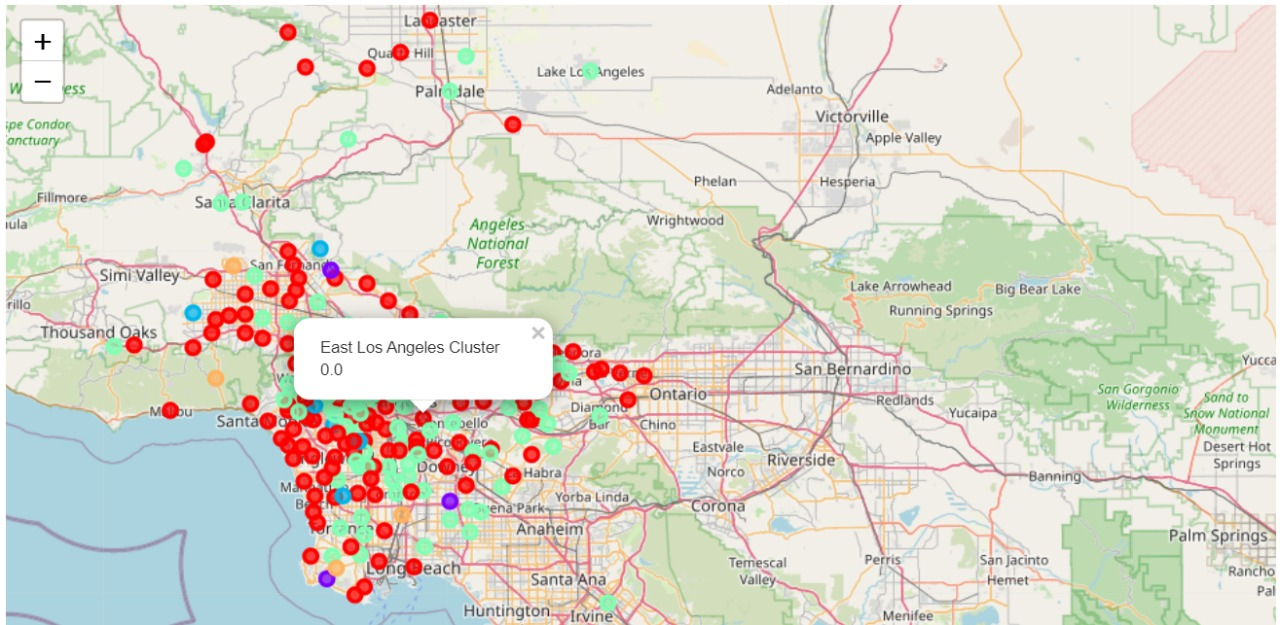

### EXAMINE NEIGHBORHOOD

### CLUSTER 1

In [70]:
la_merged.loc[la_merged['ClusterLabels'] == 0, la_merged.columns[[0] + [2] + list(range(5, la_merged.shape[1]))]].head(10)

,Neighborhood,Population,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Long Beach,462731.0,0.0,Bar,Hotel,American Restaurant,Ice Cream Shop,Italian Restaurant,Brewery,Pizza Place,Chinese Restaurant,Plaza,Wine Bar
1,Glendale,195047.0,0.0,Coffee Shop,Discount Store,Grocery Store,Seafood Restaurant,Mexican Restaurant,Shoe Store,Furniture / Home Store,Supermarket,French Restaurant,Bowling Alley
3,Pomona,150269.0,0.0,Coffee Shop,Bar,Nightclub,Music Venue,Mexican Restaurant,Seafood Restaurant,Shipping Store,Boutique,BBQ Joint,Cocktail Bar
5,Pasadena,134941.0,0.0,American Restaurant,Sushi Restaurant,Steakhouse,Dessert Shop,Hotel,Burger Joint,Japanese Restaurant,Cosmetics Shop,Furniture / Home Store,Coffee Shop
6,East Los Angeles,125897.0,0.0,Bakery,Sporting Goods Shop,Chinese Restaurant,Track,Donut Shop,Furniture / Home Store,Mexican Restaurant,Sandwich Place,Farm,Entertainment Service
7,Lancaster,120783.0,0.0,Liquor Store,Pet Store,Bar,Field,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market
9,El Monte,116249.0,0.0,Mexican Restaurant,Fast Food Restaurant,Mobile Phone Shop,Pet Store,Sandwich Place,Grocery Store,Clothing Store,Train Station,Coffee Shop,Restaurant
11,Inglewood,112482.0,0.0,Pizza Place,Caribbean Restaurant,BBQ Joint,Bus Station,Cosmetics Shop,Café,Rental Car Location,African Restaurant,Cupcake Shop,Bank
12,Downey,107323.0,0.0,Shoe Store,Football Stadium,Fried Chicken Joint,American Restaurant,Track,High School,Fast Food Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant
13,West Covina,104893.0,0.0,Pizza Place,Clothing Store,Grocery Store,Gym / Fitness Center,Hardware Store,Mediterranean Restaurant,Bakery,Deli / Bodega,Fish & Chips Shop,Financial or Legal Service


### CLUSTER 3

In [71]:
la_merged.loc[la_merged['ClusterLabels'] == 2, la_merged.columns[[0] + [2] + list(range(5, la_merged.shape[1]))]].head(10)

,Neighborhood,Population,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
88,West Hills,38814.0,2.0,Park,Business Service,Yoga Studio,Entertainment Service,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
116,Baldwin Hills/Crenshaw,30123.0,2.0,Park,Music Venue,Yoga Studio,Field,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market
165,Montecito Heights,16768.0,2.0,Park,Yoga Studio,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
192,Harvard Park,10297.0,2.0,Park,Yoga Studio,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
208,Alondra Park,8604.0,2.0,Gym / Fitness Center,Park,Electronics Store,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market
220,Beverlywood,6080.0,2.0,Park,Picnic Area,Yoga Studio,Fast Food Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm
253,Lopez/Kagel Canyons,697.0,2.0,Park,Yoga Studio,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant


### CLUSTER 4

In [86]:
la_merged.loc[la_merged['ClusterLabels'] == 3, la_merged.columns[[0] + [2] + list(range(5, la_merged.shape[1]))]].head(10)

,Neighborhood,Population,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Santa Clarita,157447.0,3.0,Park,Intersection,Pool,Home Service,Yoga Studio,Field,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant
4,Torrance,137933.0,3.0,Performing Arts Venue,Recreation Center,Theater,Pool,Event Space,Fast Food Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant
8,Palmdale,117432.0,3.0,Fast Food Restaurant,Pizza Place,Convenience Store,Mexican Restaurant,Thai Restaurant,Cajun / Creole Restaurant,Donut Shop,Sandwich Place,Gym / Fitness Center,Sushi Restaurant
10,Koreatown,115070.0,3.0,Korean Restaurant,Café,Japanese Restaurant,Ice Cream Shop,Restaurant,Bubble Tea Shop,Coffee Shop,Brazilian Restaurant,Bakery,Burger Joint
14,Westlake,103839.0,3.0,Clothing Store,Fast Food Restaurant,Coffee Shop,Supermarket,Theater,Donut Shop,Sandwich Place,Bed & Breakfast,Arts & Crafts Store,Thai Restaurant
15,Van Nuys,103770.0,3.0,Convenience Store,Mexican Restaurant,Chinese Restaurant,Sandwich Place,Restaurant,Bank,Burger Joint,South American Restaurant,Shoe Store,Shipping Store
17,Burbank,100316.0,3.0,Sandwich Place,Cuban Restaurant,Mexican Restaurant,Spa,Fast Food Restaurant,Tanning Salon,Warehouse Store,Rental Service,Concert Hall,Deli / Bodega
18,South Gate,96418.0,3.0,Bakery,Pharmacy,Mexican Restaurant,Fast Food Restaurant,Seafood Restaurant,Beer Garden,Sandwich Place,Asian Restaurant,Supplement Shop,Video Game Store
19,Compton,94384.0,3.0,Fast Food Restaurant,Pizza Place,Video Game Store,Discount Store,Grocery Store,Pharmacy,Clothing Store,Sandwich Place,Mexican Restaurant,Bank
20,Boyle Heights,92756.0,3.0,Grocery Store,Fast Food Restaurant,Bakery,Mexican Restaurant,Dive Bar,Cosmetics Shop,Bank,Sushi Restaurant,Burger Joint,Café


Taking East Los Angeles as a potential neighborhood.
(Analysis is stated below on the analysis section)

#### CHECKING POTENTIAL NEIGHBORHOOD (EAST LOS ANGELES)

In [77]:
neighborhood_latitude = la_merged.loc[6, 'Neigh_latitude'] # neighborhood latitude value
neighborhood_longitude = la_merged.loc[6, 'Neigh_longitude'] # neighborhood longitude value

neighborhood_name = la_merged.loc[6, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

search_query = 'Gym'
radius = 3000

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)

# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered


Latitude and longitude values of East Los Angeles are 34.0239015, -118.1720157.


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,categories,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,address,crossStreet,id
0,hilda solis workout room/gym,Gym,34.039097,-118.172539,"[{'label': 'display', 'lat': 34.03909683227539...",1692,90022,US,Los Angeles,CA,United States,"[Los Angeles, CA 90022, United States]",NaN,NaN,50f9f875e4b0ef4b8eb5701d
1,East Los Angeles College - Women's Gym,Gym,34.042021,-118.148844,"[{'label': 'display', 'lat': 34.04202130419063...",2939,91754,US,Monterey Park,CA,United States,"[1301 Avenida Cesar Chavez, Monterey Park, CA ...",1301 Avenida Cesar Chavez,NaN,4d065307c2e53704201dc367
2,House Gym,None,34.005180,-118.160471,"[{'label': 'display', 'lat': 34.00518, 'lng': ...",2340,90040,US,Commerce,CA,United States,"[Fitzgerald Ave (Harbor Ave), Commerce, CA 900...",Fitzgerald Ave,Harbor Ave,4d3848239516236a58b59451
3,Gym at Noho14,None,34.025475,-118.205715,"[{'label': 'display', 'lat': 34.02547538333334...",3114,90023,US,North Hollywood,CA,United States,"[Lankershim, North Hollywood, CA 90023, United...",Lankershim,NaN,4e3c2b6f1838cb1b82de53a8
4,Chunky Club Gym,Gym / Fitness Center,34.029977,-118.141677,"[{'label': 'display', 'lat': 34.02997679611101...",2879,90640,US,Montebello,CA,United States,"[765 Simmons (Dewar), Montebello, CA 90640, Un...",765 Simmons,Dewar,4d5f6d95ef378cfaf9d06fa6
5,3RD Street Gym,Gym,34.000955,-118.149472,"[{'label': 'display', 'lat': 34.000955, 'lng':...",3294,NaN,US,NaN,California,United States,"[California, United States]",NaN,NaN,4e854dd9f790ec9ce4abd485
6,Jin's Gym,Athletics & Sports,34.039886,-118.138338,"[{'label': 'display', 'lat': 34.039886, 'lng':...",3580,NaN,US,Commerce,CA,United States,"[Commerce, CA, United States]",NaN,NaN,5168cd04e4b0fc9f2ba3672e
7,Gymboree Outlet,Outlet Store,34.006633,-118.153227,"[{'label': 'display', 'lat': 34.006633, 'lng':...",2588,90040,US,Commerce,CA,United States,"[100 Citadel Dr, Commerce, CA 90040, United St...",100 Citadel Dr,NaN,4de19191d164df8574e70029
8,AltaMed University & Training Center,Non-Profit,34.008778,-118.156459,"[{'label': 'display', 'lat': 34.00877783037681...",2212,90040,US,Commerce,CA,United States,"[2035 Camfield Ave (at Telegraph Ave), Commerc...",2035 Camfield Ave,at Telegraph Ave,4bc5001cc839ef3b4a8a304e
9,Salesian High School Gymnasium,Basketball Court,34.035291,-118.204852,"[{'label': 'display', 'lat': 34.03529128123329...",3283,90033,US,Los Angeles,CA,United States,"[Los Angeles, CA 90033, United States]",NaN,NaN,50a01b4be4b064bf6d91896d


Now we need to drop unrelatted gym venues such as private school gym or clothing store

In [78]:
dataframe_filtered = dataframe_filtered.drop(labels=[1,7,8,9], axis=0)
  
dataframe_filtered

,name,categories,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,address,crossStreet,id
0,hilda solis workout room/gym,Gym,34.039097,-118.172539,"[{'label': 'display', 'lat': 34.03909683227539...",1692,90022,US,Los Angeles,CA,United States,"[Los Angeles, CA 90022, United States]",NaN,NaN,50f9f875e4b0ef4b8eb5701d
2,House Gym,None,34.005180,-118.160471,"[{'label': 'display', 'lat': 34.00518, 'lng': ...",2340,90040,US,Commerce,CA,United States,"[Fitzgerald Ave (Harbor Ave), Commerce, CA 900...",Fitzgerald Ave,Harbor Ave,4d3848239516236a58b59451
3,Gym at Noho14,None,34.025475,-118.205715,"[{'label': 'display', 'lat': 34.02547538333334...",3114,90023,US,North Hollywood,CA,United States,"[Lankershim, North Hollywood, CA 90023, United...",Lankershim,NaN,4e3c2b6f1838cb1b82de53a8
4,Chunky Club Gym,Gym / Fitness Center,34.029977,-118.141677,"[{'label': 'display', 'lat': 34.02997679611101...",2879,90640,US,Montebello,CA,United States,"[765 Simmons (Dewar), Montebello, CA 90640, Un...",765 Simmons,Dewar,4d5f6d95ef378cfaf9d06fa6
5,3RD Street Gym,Gym,34.000955,-118.149472,"[{'label': 'display', 'lat': 34.000955, 'lng':...",3294,NaN,US,NaN,California,United States,"[California, United States]",NaN,NaN,4e854dd9f790ec9ce4abd485
6,Jin's Gym,Athletics & Sports,34.039886,-118.138338,"[{'label': 'display', 'lat': 34.039886, 'lng':...",3580,NaN,US,Commerce,CA,United States,"[Commerce, CA, United States]",NaN,NaN,5168cd04e4b0fc9f2ba3672e


In [85]:

map_ela = folium.Map(location=[neighborhood_latitude, neighborhood_longitude], zoom_start=14)

# add a red circle marker to represent the East Los Angeles
folium.CircleMarker(
    [neighborhood_latitude, neighborhood_longitude],
    radius=10,
    color='red',
    popup='East Los Angeles',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_ela)

# add the Gym as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(map_ela)

# display map
map_ela

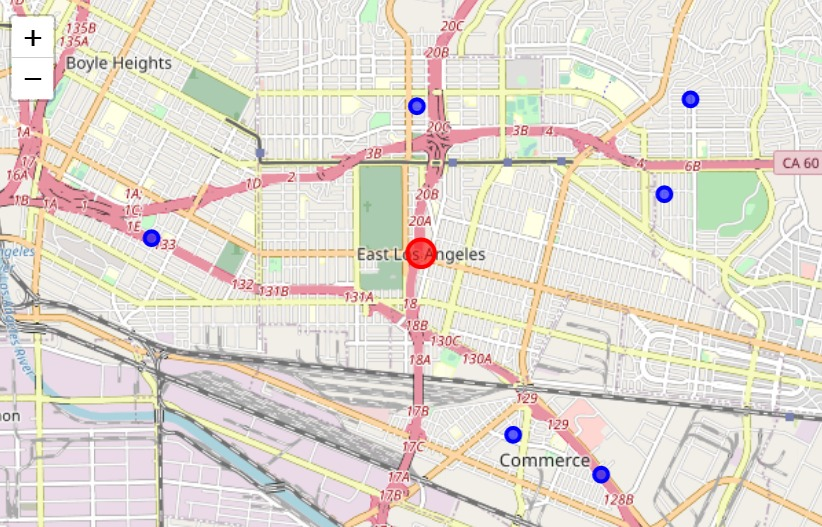

## D. Result and Discussion

From clustering above, we can see that there are 3 big cluster (Cluster 1,3,4) and 2 smaller cluster (Cluster 2,5). In this case we will take a look at 3 biggest cluster that are Cluster 1, 3, and 4.

Los Angeles is a big county, venues are almost fairly distributed causing some cluster looks a bit similar. Although their similarities, we can derive some differences too. Here are description for cluster analysis:

Cluster1 : Big neighborhood with the most population among other cluster. Having various choice of restaurants as its common venue. Having lots of good place for socializing, for fun and entertainment such as, music venue, nightclub, event space, stadium, bowling alley, escape room and recreation center. Having various kind of place to enjoy food/drink/snack such as, restaurant, cafe, bakery, dessert, coffee/tea shops, and bar. Having various places to shop like mobile phone, grocery, cosmetic, clothing, hardware, and furniture. Overall it is a typical urban core neighborhood with a complete and diverse facilities in it.

Cluster 3: Place for various activities outdoor. Main venues are parks. Having only some type of restaurants like english, ethiopian, or falafel restaurant. Good place for relaxing by doing yoga. Also having some entertainment venues and farm. Generally it looks like a suburban neighborhood.

Cluster 4: Similar to cluster1, which has a lot of various restaurant except dominated with fastfood. Lot of venues for activity as well such as bowling, pool, theatre, yoga, and event space. There are lots of place to shop daily needs and they are distributed everywhere such as grocery store, convenience store, supermarket and farmer's market. Overall, it's a type of residential place that is good for living.

While it is important to open Gym at a good residential type of neighborhood, it is also important to target correct market that are going to use the gym service, like Cluster 1 type of neighborhood. It is a type of urban core neighborhood which has a lot of people reside and fit our target which is people who would like to pursue career in entertainment industry. Gym members are likely belong to a facility that is located near where they live. In that case, we need to find one best neighborhood in the cluster 1 which has big enough population and also having supportive common venues, such as health related things. In this case, we choose East Los Angeles as the most recommended place to open Gym. It's because it has big enough population among its cluster. Also, looking at its characteristic of neighborhood, East Los Angeles has a lot of common facilities/venues which is in line with health caring such as Bakery, Sporting Goods Shop, Track, Sandwich Place, and Farm. It also doesn't have unhealthy venues as its common venues such as Bar, Liquor Store, and Fast Food Restaurant, even though other have them. Lastly we check about the compititors and Gym doesn't appear in the 10th most common venues list. This means that Gym is not categorized as common facilities in this neighborhood yet. We did a re-check to make sure that there are only few competitors nearby and it shows that there are only 6 gym within 3000kms from the centre which not too much considering its population number. From this, we can make a conclusion that East Los Angeles is a good place to open Gym.

## E. Conclusion

Purpose of this project was to make a recommendation of a location in Los Angeles County to open gym. In order to narrow down the location we pick a neighborhood which has a specific characteristic, such as number of population and the neighborhood type itself. By collecting data from all venues and checking their location, we can conclude type and characteristic of the neighborhood which has some venues close to it. In this case, we got 3 main clusters derived from its most common venue nearby. Surprisingly, it is hard to distinguish one to another cluster because of its similarity, that might be a typical big city character as facilities are fairly distributed. Cluster analysis shows that cluster 1 is a good potential location for opening new business because of its characteristic of urban core neighborhood that might highly attract more people within the project target to live there. East Los Angeles is one of a neighborhood on cluster 1 that has big population but not considered too crowded. By checking its most common venues, we can see that East Los Angeles has supportive facilities for keeping up with health related things, such as sport shop, healthy food, and healthy market. After did a recheck, it can also be seen that there are only few gym competitors nearby. Finally, we can recommend that East Los Angeles is a good location to open gym based on current environment, also for future, considering the good characteristic of neighborhood itself.